# Optimal UTXO size for difficulty and static reward

Quickly find the optimal Peercoin UTXO size for a given difficulty and static reward. Parameters can be adjusted for the displayed chart.

This uses daily probabilities as an approximation for per-second probabilities. It also assumes minting occurs continuously.

Determines the probability distribution for mints across multiple days and then finds a geometric average reward weighted by these probabilities.

Produced by MattLM with credit to Nagalim for ideas and alternative solutions.

Tips are welcome: PTuwboaoow7XF7Vrr68oremimo9wgrvxQ6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 5.0]

## Parameters

In [2]:
MAX_DAYS = 365*4
MIN_PROB_DAYS=30
RAMP_UP = 60
RELATIVE_REWARD = 0.03
BLOCK_INTERVAL_SECS = 60*10
# Supply in coins. Whilst the total supply can be used, some coins may be considerated irredeemable.
# However, with some flag combinations, this supply is now used in the calculations.
SUPPLY = 28285814
# PoS block frequency in seconds
BLOCKTIME = 600
# Minimum Output Size
DUST = 0.01

In [3]:
DIFF = 19.76
# Static reward as a percentage of supply (or fixed amount, if you turn off the tag further down)
STATIC_REWARD = 0.25
EXAMPLE_SIZE = 100
# EXAMPLE_MILLIPERCENT = 0.3535

# Recommended to keep False.
# This compounds the return of a single-output.
# This under-estimates returns for a wallet with many small utxos as
# the slow-compounding effects are removed when there are many outputs.
GEOMETRIC=False

## Helpful constants

In [4]:
SECDAY=60*60*24
DAYYEAR=(365*33+8)/33
# Offset days by 0.5 to assume mint occurs somewhere in middle of day
DAYS = [MIN_PROB_DAYS+x+0.5 for x in range(MAX_DAYS)]
NO_MINT_DAY = MAX_DAYS+MIN_PROB_DAYS
DAYS_WITH_NO_MINT = DAYS + [NO_MINT_DAY]
# Blocks per year
BLOCKYEAR = SECDAY * DAYYEAR / BLOCKTIME

In [5]:
# Fixed Static reward calculation
FIXEDSTATIC = False
if FIXEDSTATIC:
    STATIC = STATIC_REWARD
else:
    STATIC = STATIC_REWARD * SUPPLY / (100 * BLOCKYEAR)

In [6]:
# 'scaled difficulty' is a tag to turn off security parameter definitions.
# it is recommended that you leave this on unless you are modeling transient forking behavior.
# If you would prefer to just define security parameter directly and ignore the concept of difficulty:
#   you can turn off 'scaled difficulty' and use the difficulty in place of the unormsecure parameter.
SCALEDDIFFICULTY=True
# Calculate Unnormalized Security Parameter
if SCALEDDIFFICULTY:
    UNORMSECURE = 2**32 * DIFF * (BLOCKTIME/600) / 60
else:
    UNORMSECURE = DIFF
#TODO: More thorough, real-chain grounded definition of security parameter
GeomApprox = ((1-(DUST / UNORMSECURE))**SECDAY)**(MAX_DAYS-MIN_PROB_DAYS-RAMP_UP/2)
SECURENORM = (1-GeomApprox)/(MAX_DAYS*GeomApprox)/0.01*365
SECURITY = 100 * BLOCKYEAR / (SECURENORM * SUPPLY)
print("Approximate Security Parameter = %2.2f%%"%(SECURITY))
#TODO: Feed Accurate Security Parameter back into normalized security definition

Approximate Security Parameter = 8.69%


## Calculate daily probability distribution

Includes the rampup

In [7]:
# Ramp from 0 to 1
SecurityWeights = (np.arange(RAMP_UP)+0.5)/RAMP_UP
print(SecurityWeights)
# Fill out the rest of the weights with the maximum of 1
MaxWeight = np.ones(MAX_DAYS-RAMP_UP)
rampWeights = np.append(SecurityWeights,MaxWeight)
Security_probSecs = rampWeights

[0.00833333 0.025      0.04166667 0.05833333 0.075      0.09166667
 0.10833333 0.125      0.14166667 0.15833333 0.175      0.19166667
 0.20833333 0.225      0.24166667 0.25833333 0.275      0.29166667
 0.30833333 0.325      0.34166667 0.35833333 0.375      0.39166667
 0.40833333 0.425      0.44166667 0.45833333 0.475      0.49166667
 0.50833333 0.525      0.54166667 0.55833333 0.575      0.59166667
 0.60833333 0.625      0.64166667 0.65833333 0.675      0.69166667
 0.70833333 0.725      0.74166667 0.75833333 0.775      0.79166667
 0.80833333 0.825      0.84166667 0.85833333 0.875      0.89166667
 0.90833333 0.925      0.94166667 0.95833333 0.975      0.99166667]


In [8]:
def generateDailyProbs(outValue, diff):
    
    adj = outValue / UNORMSECURE

    # Independent probabilities
    failDayProbs = (1 - Security_probSecs*adj)**SECDAY
    mintDayProbs = 1 - failDayProbs

    # Actual probability of mint on day assuming no mints before
    cumFail = failDayProbs.cumprod()
    # Prob of fail up-to now
    cumPrevFail = np.insert(cumFail, 0, 1)[:MAX_DAYS]
    # Prob of fail up-to now and success now gives chance of mint on this day
    # Add probabilty of final day to represent no successful mints
    return np.append(cumPrevFail*mintDayProbs, cumFail[-1])
        

In [9]:
dayProbs = generateDailyProbs(EXAMPLE_SIZE, DIFF)

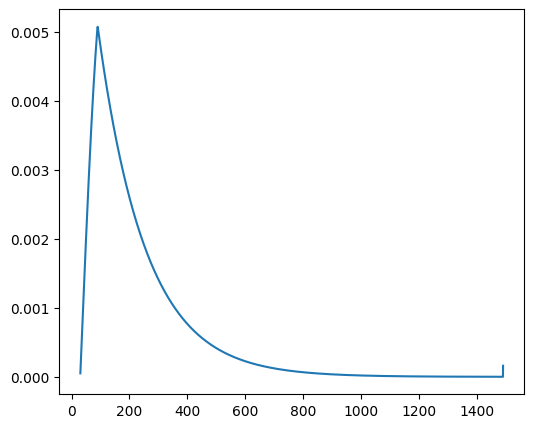

In [10]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs)
plt.show()

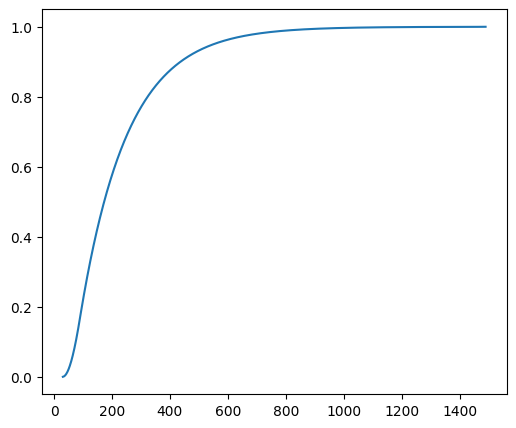

In [11]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs.cumsum())
plt.show()

In [12]:
# Should add up to 1
dayProbs.sum()

1.0000000000000002

## Calculate Geometric average of rewards weighted by probabilities

In [13]:
def dailyRewards(outValue, staticReward):
    mintRewards = np.fromiter((outValue*RELATIVE_REWARD*min(365, x)/DAYYEAR + staticReward for x in DAYS), dtype=float)
    includingFailed = np.append(mintRewards, 0)
    return includingFailed

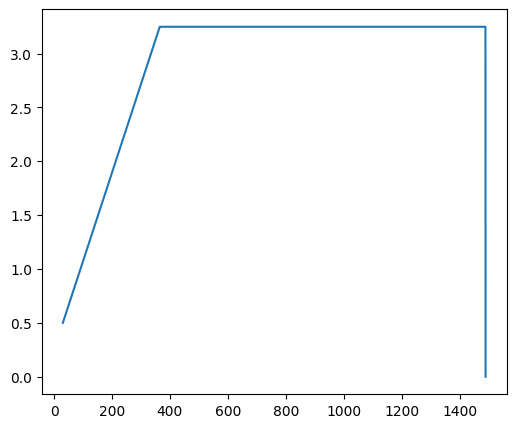

In [14]:
rewards = dailyRewards(EXAMPLE_SIZE, STATIC_REWARD)
plt.plot(DAYS_WITH_NO_MINT, rewards)
plt.show()

In [15]:
def averageReward(outValue, diff, staticReward, geometric=GEOMETRIC):
    probs = generateDailyProbs(outValue, diff)
    rewards = dailyRewards(outValue, staticReward)
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()

    if geometric:
        returns = 1+rewards/outValue
        weightedReturn = (returns**probs).prod()
        return (weightedReturn**(DAYYEAR/weightedTime) - 1) * 100

    # Arithmetic
    returns = rewards/outValue
    weightedReturn = (returns*probs).sum()
    return (weightedReturn*(DAYYEAR/weightedTime)) * 100

In [16]:
averageReward(EXAMPLE_SIZE, DIFF, STATIC_REWARD)

3.067201212726528

## Plot UTXO sizes

In [17]:
sizes = [10**(x/125) for x in range(501)]

In [18]:
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC) for x in sizes), dtype=float)

In [19]:
def addFigText(optimal):
    plt.figtext(0.5, -0.03, f"Additional parameters: percentage reward={RELATIVE_REWARD*100}%, min days={MIN_PROB_DAYS}, ramp days={RAMP_UP}, max days={MAX_DAYS}, geometric={GEOMETRIC}", ha="center", fontsize=10)
    plt.figtext(0.5, -0.08, f"Optimal UTXO Size: {optimal:.6f} PPC", ha="center", fontsize=10)

In [20]:
def plotResults(results, yLabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, results)
    ax.set_xlabel("UTXO Size")
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    addFigText(sizes[results.argmax()])
    plt.xscale("log")
    plt.grid(which="both")
    plt.show()

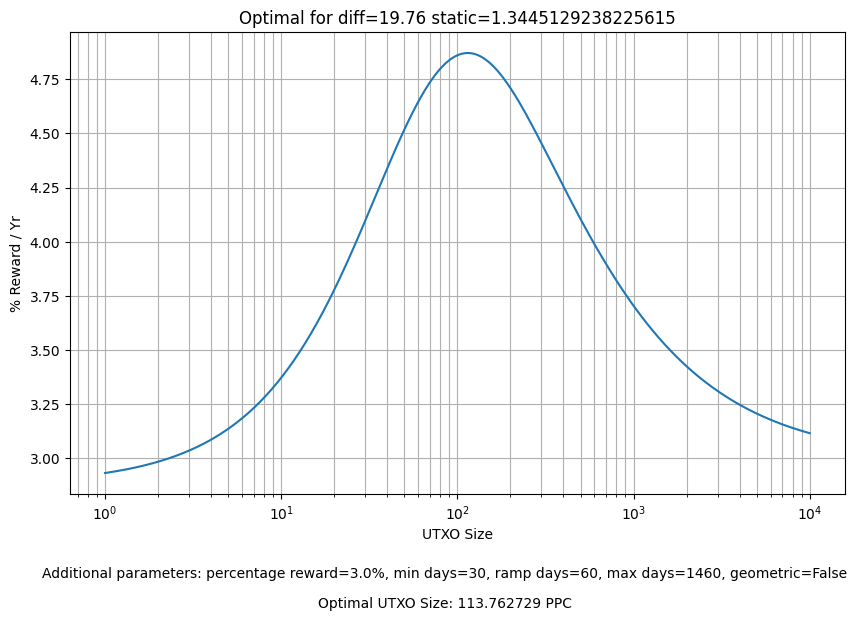

In [21]:
plotResults(rewardForSizes, "% Reward / Yr", f"Optimal for diff={DIFF} static={STATIC}")

## Number of Mints

In [22]:
def averageMints(outValue, diff):
    probs = generateDailyProbs(outValue, diff)
    probFail = probs[-1]
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (1-probFail)/weightedTime/outValue*365

In [23]:
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in sizes), dtype=float)

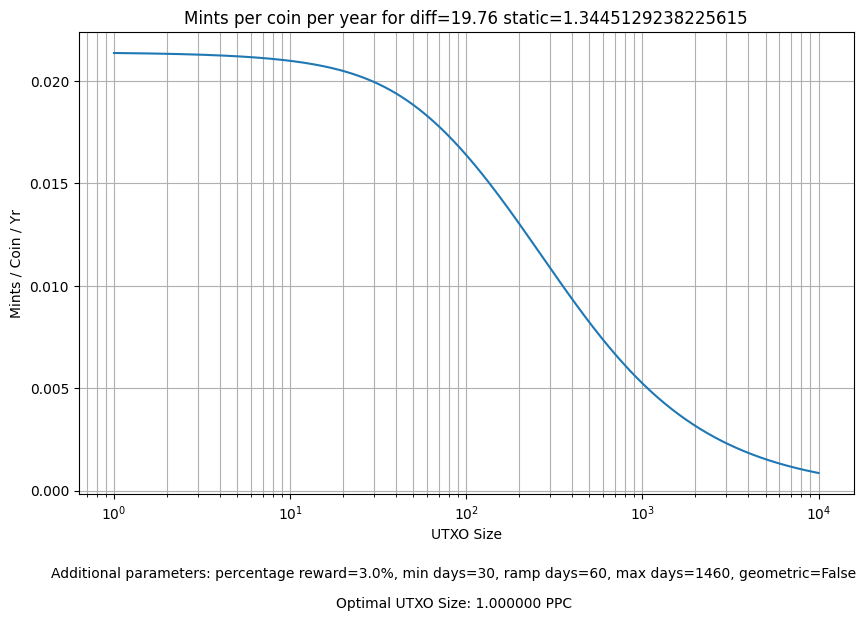

In [24]:
plotResults(mintsForSizes, "Mints / Coin / Yr", f"Mints per coin per year for diff={DIFF} static={STATIC}")

## Security

The percentage of supply at full optimisation required to meet the block interval at current difficulty.

In [25]:
mintsPerCoinInterval = averageMints(0.01, DIFF) * BLOCK_INTERVAL_SECS / 365 / 24 / 60 / 60
expectedMintsAtFullSupply = mintsPerCoinInterval * SUPPLY
securityLevel = 1/expectedMintsAtFullSupply
print(f"Security Level = {securityLevel*100:.2f}%")

Security Level = 8.68%


## Combined Chart

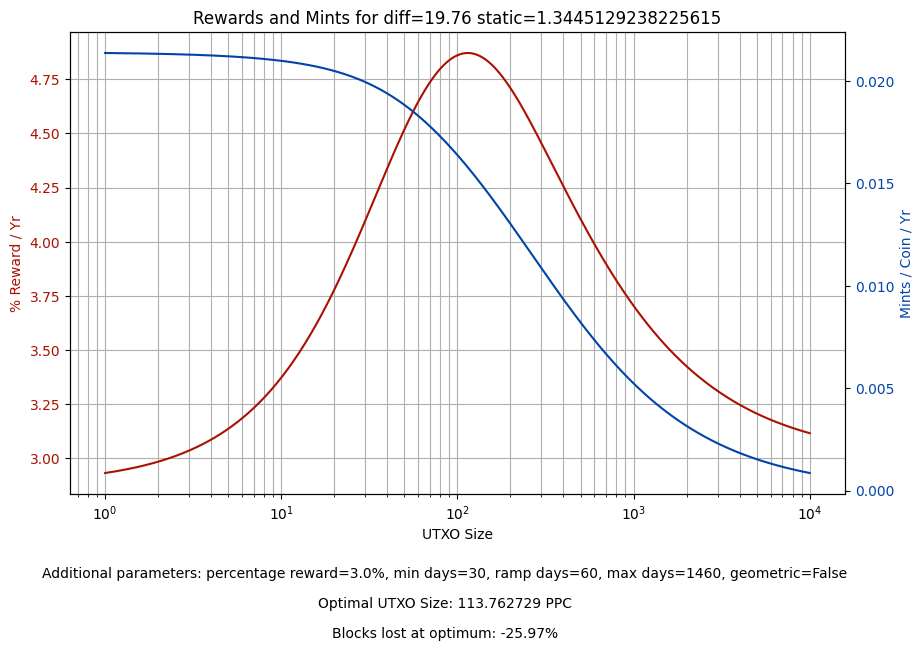

In [26]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Rewards and Mints for diff={DIFF} static={STATIC}")
rewardAx.set_xlabel("UTXO Size")

colour = "#A10"
rewardAx.plot(sizes, rewardForSizes, color=colour)
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

mintsAx = rewardAx.twinx()
colour = "#04A"
mintsAx.plot(sizes, mintsForSizes, color=colour)
mintsAx.tick_params(axis ='y', labelcolor=colour) 
mintsAx.set_ylabel("Mints / Coin / Yr", color=colour)

addFigText(sizes[rewardForSizes.argmax()])

blockLoss = (1 - mintsForSizes[rewardForSizes.argmax()] / mintsForSizes.max())*100
plt.figtext(0.5, -0.13, f"Blocks lost at optimum: -{blockLoss:.2f}%", ha="center", fontsize=10)

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()

## Optimal UTXO Size

In [27]:
# UTXO Size
maxI = rewardForSizes.argmax()
sizes[maxI]

113.7627285823431

In [28]:
# Reward
maxReward = rewardForSizes.max()
maxReward

4.871671197012582

In [29]:
def findWithinTolerance(it, tolerance):
    for i in it:
        if (maxReward - rewardForSizes[i] > tolerance):
            return sizes[i+1]

In [30]:
# -10bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.1)

75.85775750291836

In [31]:
# -10bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.1)

180.3017740859568

In [32]:
# -20bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.2)

63.09573444801933

In [33]:
# -20bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.2)

220.80047330188992

## Multi-output Simulation

Since the geometric simulation looks at a single output in isolation, a wallet containing many smaller outputs may produce a different outcome.

In [34]:
import random, math

In [35]:
def randomDaysToMint(size):

    adj = size * 60 / (DIFF * 2**32)
    daysToMint=MIN_PROB_DAYS+0.5
    dayProbs = 1 - (1 - Security_probSecs[:RAMP_UP+1]*adj)**SECDAY

    for x in range(RAMP_UP):
        if random.random()<dayProbs[x]:
            return daysToMint
        daysToMint+=1

    days = daysToMint+np.random.geometric(dayProbs[-1])
    return days if days < NO_MINT_DAY else NO_MINT_DAY

def calcReward(size, daysToMint):
    return 0 if daysToMint == NO_MINT_DAY else size*RELATIVE_REWARD*min(365, daysToMint)/DAYYEAR + STATIC

def multiSim(size, n, sims=50000):

    # Split if over size*2^0.5
    maxSize = size*2**0.5
    
    startBalance = size*n
    simDay = 0

    mintDayIndices = np.random.choice(MAX_DAYS+1, size=n, p=generateDailyProbs(size, DIFF))
    nextMintDays = np.take(DAYS_WITH_NO_MINT, mintDayIndices)
    nextMintRewards = np.take(dailyRewards(size, STATIC), mintDayIndices)
    outBalances = np.full(n, size, dtype=float)

    for i in range(sims):
        
        simDay = nextMintDays.min()
        index = nextMintDays.argmin()

        newBalance = outBalances[index] + nextMintRewards[index]

        # Split?
        if newBalance > maxSize:
            newBalance /= 2

            # Add new split utxo
            daysToMint = randomDaysToMint(newBalance)
            reward = calcReward(newBalance, daysToMint)
            nextMintDays = np.append(nextMintDays, simDay + daysToMint)
            nextMintRewards = np.append(nextMintRewards, reward)
            outBalances = np.append(outBalances, newBalance)

        # Update current utxo
        daysToMint = randomDaysToMint(newBalance)
        reward = calcReward(newBalance, daysToMint)
        nextMintDays[index] = simDay + daysToMint
        nextMintRewards[index] = reward
        outBalances[index] = newBalance;            
            
    endBalance = outBalances.sum()
    return ((endBalance/startBalance)**(DAYYEAR/nextMintDays.min())-1)*100

In [36]:
def simAndPrint(size, n):
    size = math.floor(size*1000000)/1000000
    print(f"{size}*{n}")
    return multiSim(size, n)

In [37]:
simSizes = [10**(x/10) for x in range(41)]
simulatedReward = np.fromiter((simAndPrint(x, int(10000//x)) for x in simSizes), dtype=float)

1.0*10000
1.258925*7943
1.584893*6309
1.995262*5011
2.511886*3981
3.162277*3162
3.981071*2511
5.011872*1995
6.309573*1584
7.943282*1258
10.0*1000
12.589254*794
15.848931*630
19.952623*501
25.118864*398
31.622776*316
39.810717*251
50.118723*199
63.095734*158
79.432823*125
100.0*100
125.892541*79
158.489319*63
199.526231*50
251.188643*39
316.227766*31
398.10717*25
501.187233*19
630.957344*15
794.328234*12
1000.0*10
1258.925411*7
1584.893192*6
1995.262314*5
2511.886431*3
3162.27766*3
3981.071705*2
5011.872336*1
6309.573444*1
7943.282347*1
10000.0*1


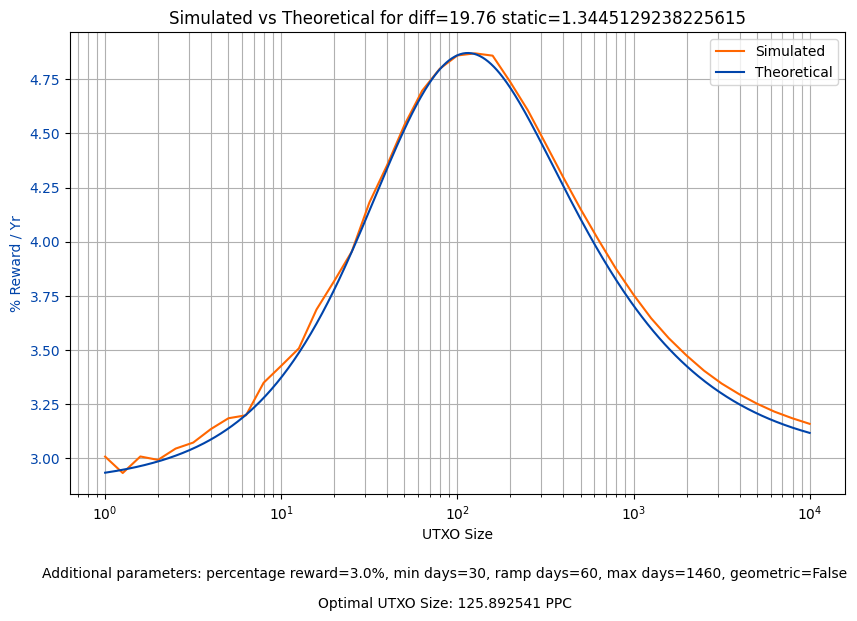

In [38]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Simulated vs Theoretical for diff={DIFF} static={STATIC}")
rewardAx.set_xlabel("UTXO Size")
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

p1, = rewardAx.plot(simSizes, simulatedReward, color="#F60", label="Simulated")
p2, = rewardAx.plot(sizes, rewardForSizes, color="#04A", label="Theoretical")
rewardAx.legend(handles=[p1, p2])

addFigText(simSizes[simulatedReward.argmax()])

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()